# Challenge 2 - Identify a signal in colored Gaussian noise
Amélie Orban, 14/02/22.  

Use the data file "challenge2.gwf". The channel name is "H1:CHALLENGE2".
The data is colored, Gaussian noise containing a simulated BBH signal with m1=m2=30 solar masses (1 solar mass = 1.989 x 10^30 kilograms), spin = 0. [Link to the data file.](https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf)


## Install and import statements
Firstly, and as for the last challenge, numerous librairies and packages have to be installed and they must be imported into the code to be used. Note that some additional packages are installed and imported into the code compared to the previous challenge, as more GW data analysis tools will be used in this challenge.

In [ ]:
# Installing the necessary packages
# For GW data analysis
! pip install -q 'gwosc==0.5.4' 
! pip install -q 'lalsuite==6.82' 'PyCBC==1.18.0'
! pip install -q 'gwpy==2.0.2'
# For plotting
%matplotlib inline

In [ ]:
# Importing the packages in the code
import numpy
import pylab
import pycbc
from pycbc.waveform import get_td_waveform
from pycbc import frame
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import matched_filter
import gwpy
from gwpy.timeseries import TimeSeries

## Downloading and plotting the data
The second step, before getting into the different tasks of the challenge, is to download the data and store it into an object by reading the file and assigning the informations to the data object. This can then be used to analyse the data and its various features. 

We also print some of the characteristics of this data, such as the sampling rate, the time values, and the duration, and we plot it just to get an idea of what the looks like.

In [ ]:
# Download the data (change name! ->  challenge 2)
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

# Create a strain object using GWPY and PYCBC (change names! ->  challenge 2)
  # The PYCBC object will be used later on when computing the SNR of the data
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')
# Can print the content of the strain object to see the info it contains
print("This is the strain object created with the Challenge 2 data: \n", gwpy_strain)

--2022-02-13 19:57:22--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf.1’

challenge2.gwf.1    100%[===================>]   3.84M  1.53MB/s    in 2.5s    

2022-02-13 19:57:26 (1.53 MB/s) - ‘challenge2.gwf.1’ saved [4025842/4025842]

This is the strain object created with the Challenge 2 data: 
 TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: H1:CHALLENGE2)


In [ ]:
# Retrieve and print the sampling rate (rate of samples per second [Hz]) and duration of the data

sample_rate = 1.0/gwpy_strain.dt # dt = time between successive samples [s]
print("\n The sampling rate of the data is: ", sample_rate)

print("\n Checking the time values of this data: ", gwpy_strain.times)
len_times = len(gwpy_strain.times)
duration = gwpy_strain.times[len_times-1] - gwpy_strain.times[0]
print("\n The duration of the data is: ", duration)


 The sampling rate of the data is:  4096.0 1 / s

 Checking the time values of this data:  [-64.         -63.99975586 -63.99951172 ...  63.99926758
  63.99951172  63.99975586] s

 The duration of the data is:  127.999755859375 s


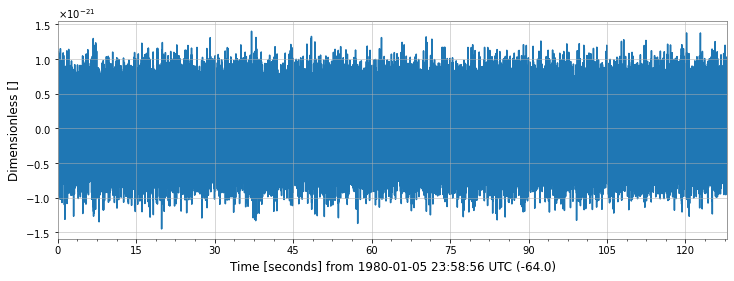

In [ ]:
# Plot the strain object containing the data
plot = gwpy_strain.plot()
ax = plot.gca()
ax.set_ylabel("Dimensionless []")
plot.show(warn=False)

## Question 1: Time of merger
*What is the approximative time of the merger? (Hint: a plot of the q-transform could help).*

In order to determine when the merger approximately happens and to be able to distinguish it from the surrounding noise, we can use a Q-transform ( create time-frequency representation of data). Using this plot of the evolution of the frequency distribution over time, the signal of the merger can be located as it should have the shape of a "chirp".



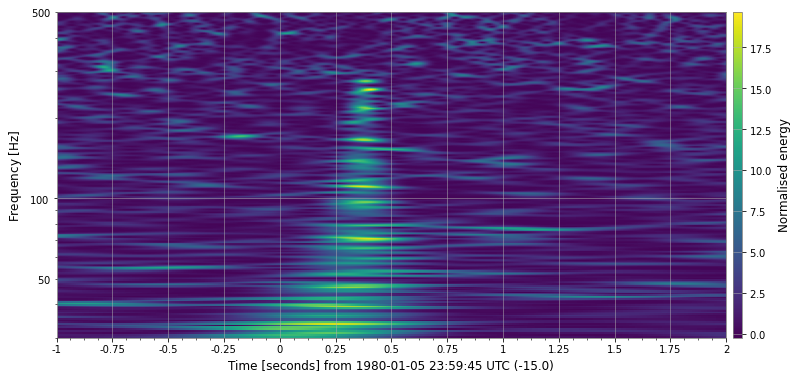

In [ ]:
# Compute the Q-transform of the data
  # frange = frequency range to scan
  # qrange = range of Qs to scan
  # use OUTSEG for smaller time range (focus on the signal)
q_gwpy_strain = gwpy_strain.q_transform(frange=(30, 500), qrange=(100,110), outseg=(-16,-13)) 

# Plot the result time-frequency representation
plot = q_gwpy_strain.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

The plot of the Q-transform shows a clear chirp signal that corresponds to the binary black hole merger signal. On the plot, this signal seems to lie at 0.4 s (approximately). Because this is only a zoomed-in portion of the data, and because of the time scale and the fact that we know that the data has a duration of 127.999755859375 s, we can deduce that the erger happens 49.4 s after the beginning of the data.

## Question 2: Creating a template
*Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.*

Now, we can create a template waveform based on what we know of the waveform signal that is contained in the data that we want to analyse. Because the black holes are expected to have no spin, the "SEOBNRv4_opt" approximant (~ model) can be used. This template will later be used as a comparison to the observed to signal to try to identify it in the data by creating a SNR (Signal-to-Noise Ratio) plot.



Text(0, 0.5, 'Normalized amplitude')

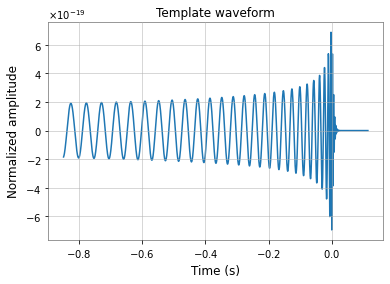

In [ ]:
# Generate a time-domain template waveform using approximate "SEOBNRv4_opt" with parameters: m1=m2=30 solar masses
  # Only the 'plus' polarization of the created waveform is kept (because it only differs from the 'cross' polarization by some phase constant)
sample_rate = 2048 # samples per second
hp, _ = get_td_waveform(approximant='SEOBNRv4_opt',
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sample_rate,
                         f_lower=20)

# Plot this waveform
pylab.figure()
pylab.title("Template waveform")
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

## Question 3: Computing a PSD of the data
*Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.*

Another step that we must take before computing the SNR time series of the data is to calculate the PSD of the data. PSD stands for power spectral density, and it is a representation of the frequency distribution of the data. 

Delta_t of the data : 0.000244140625 s
Sample rate of the data:  4096.0 1 / s
Nyquist frequency:  2048.0 1 / s


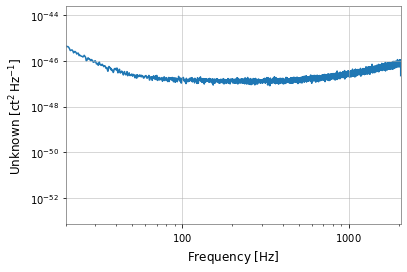

In [ ]:
# Calculate the PSD of the data
  # fftlength = 4 -> number of seconds in single FFT
  # The function then computes the average of the FFTs of each small segment of the data (Welch method)
psd = gwpy_strain.psd(4)

# Plot PSD on a log-log scale (from 20 Hz up to the Nyquist frequency)
  # Nyquist frequency = one-half of the sampling rate (which is the inverse of the dt)
sample_rate = 1.0/gwpy_strain.dt
nyq_freq = sample_rate*0.5
print("Delta_t of the data :", gwpy_strain.dt)
print("Sample rate of the data: ", sample_rate)
print("Nyquist frequency: ", nyq_freq)
# Plotting
plot = psd.plot()
ax = plot.gca()
ax.set_xlim(20, 2048)
ax.set_yscale('log')
ax.set_xscale('log')

## Question 4: Computing the SNR (matched-filtering)
*Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.*

Finally, we can now do matched-filtering and compute the actual SNR time series of the data to determine when exactly the merger signal happens (using the template waveform and the PSD of the data). This is done by comparing the template to the data and doing this comparison over all of the time points of the data, until there is a high enough correspondance which indicates that the signal is at that location. 

Before doing so, the data itself, as well as the PSD and the template, have to be preconditioned to avoid some errors and to ensure that the data, the PSD, and the template are all compatible.

In [ ]:
# Preconditioning the data

# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 20.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

# Remove the begining and ending (small portions) from the data
  # Avoid filters that act on times which are not causally connected (ensure they do not wrap around the input)
conditioned_strain = pycbc_strain.crop(2, 2)

In [ ]:
# Computing the PSD and creating the 1/PSD filter

# Compute the PSD (with pycbc_strain here)
  # Use 4 second samples (Welch method)
psd = conditioned_strain.psd(4)

# Interpolate the PSD to match the data
psd = interpolate(psd, conditioned_strain.delta_f)

# Limit the filter length of 1/PSD
  # 1/PSD will act as a filter with an effective length of 4 seconds
  # Don't include frequencies below 15 Hz, as data has been highpassed above 15 Hz
psd = inverse_spectrum_truncation(psd, int(4 * conditioned_strain.sample_rate),
                                  low_frequency_cutoff=20)

# => Now, can directly use this PSD to filter the data in a controlled manner

Text(0, 0.5, 'Strain')

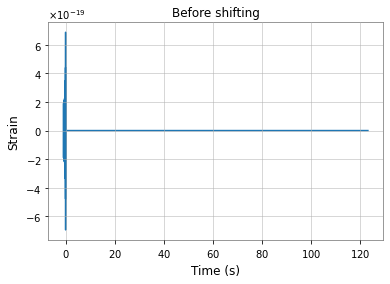

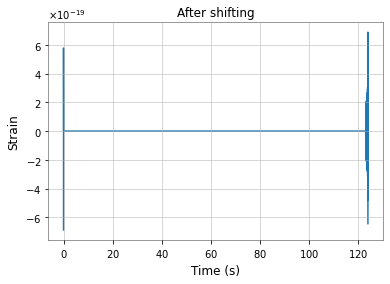

In [ ]:
# Preparing the signal template

# Resize the vector to match our data
hp.resize(len(conditioned_strain))

# Shift the template so that the beginning of the signal corresponds to the time of merger
  # If we want the SNR time series to correspond to the approximate merger location: 
  # must shift data so that the merger is at begining of the data
  # cyclic_time_shift: shifts the timeseries by a given amount of time (acts as if data if on a ring)
  # Merger is now at time zero (but start of signal is in the negatives), so we can use the start time to shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)

# Plot the signal before and after shifting for visualization
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

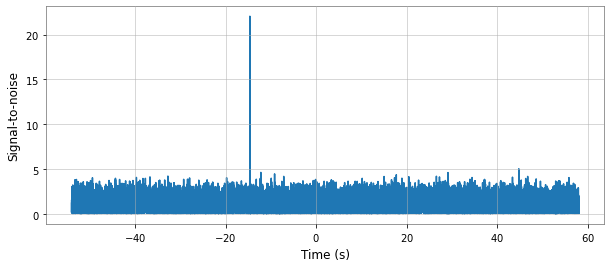

We found a signal at -14.6328125s with SNR 22.035868422850868


In [ ]:
# Calculating the Signal-to-Noise time series

snr = matched_filter(template, 
                     conditioned_strain,
                     psd=psd, 
                     low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax() # find the peak (its location in the array)
snrp = snr[peak] # get its SNR value
time = snr.sample_times[peak] # get its location (in time)

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

## Question 5: Finding the signal
*What is the matched filter SNR of the signal?*

Using the SNR plot created previously, it is very easy to locate the signal, which in this case is at -14.6328125 s. This corresponds to 49.3671875 s after the beginning of the data, which is consistent with the approximate value that was found in Question 1 using the Q-transform of the data. As for the matched filter SNR value of the signal, it has a value of 22.035868422850868, which clearly shows that there is indeed a GW signal at that location in the data (we assume a threshold on matched filter SNR of 8 to claim detection of GW).  